<a href="https://colab.research.google.com/github/valceven/Thesis_Models/blob/main/Humai_Physical_Properties_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install roboflow

from roboflow import Roboflow

rf = Roboflow(api_key="c32eqh0UKXsSvs8U2Iga")

project = rf.workspace("humai-o2qtg").project("rice-quality-3-3viu5")
version = project.version(2)
dataset = version.download("yolov8")


loading Roboflow workspace...
loading Roboflow project...


In [8]:
import yaml
import os

yaml_path = f"{dataset.location}/data.yaml"

with open(yaml_path, 'r') as f:
  data = yaml.safe_load(f)

print("--- YOUR CURRENT CLASSES ---")
print(data['names'])

--- YOUR CURRENT CLASSES ---
['broken', 'broken-chalky', 'broken-clear', 'foreign-object', 'plastic', 'sound', 'stone', 'unsound', 'whole', 'whole-chalky']


In [10]:
import os
import glob
import yaml

DATASET_PATH = dataset.location

def custom_remap_labels():
    print(f"Starting Custom Remap on: {DATASET_PATH}")

    new_names = ['Whole', 'Broken', 'Foreign Object', 'Discolored']

    # 2. Get the Old Schema from data.yaml
    yaml_path = os.path.join(DATASET_PATH, "data.yaml")
    with open(yaml_path, 'r') as f:
        data = yaml.safe_load(f)
        old_names = data['names']

    print(f"Old Classes Found: {old_names}")

    name_to_id = {
        'broken': 1,
        'broken-chalky': 1,
        'broken-clear': 1,

        'foreign-object': 2,
        'plastic': 2,
        'stone': 2,

        'sound': 0,
        'whole': 0,
        'whole-chalky': 0,

        'unsound': 3
    }


    id_map = {}
    for index, name in enumerate(old_names):
        clean_name = name.lower().strip()

        if clean_name in name_to_id:
            id_map[index] = name_to_id[clean_name]
            print(f"  Mapping '{name}' ({index}) -> {new_names[name_to_id[clean_name]]}")
        else:
            print(f"  WARNING: Class '{name}' not in your list! Defaulting to 'Foreign Object' (Safe fail)")
            id_map[index] = 2

    label_files = glob.glob(f"{DATASET_PATH}/**/labels/*.txt", recursive=True)
    print(f"\nProcessing {len(label_files)} label files...")

    for file_path in label_files:
        new_lines = []
        with open(file_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            if not parts: continue

            old_id = int(parts[0])
            coords = " ".join(parts[1:])

            if old_id in id_map:
                new_id = id_map[old_id]
                new_lines.append(f"{new_id} {coords}\n")

        with open(file_path, 'w') as f:
            f.writelines(new_lines)

    data['names'] = new_names
    data['nc'] = len(new_names)

    with open(yaml_path, 'w') as f:
        yaml.safe_dump(data, f)

    print("\n[SUCCESS] Dataset remapped to:")
    print(f"0: Whole, 1: Broken, 2: Foreign Object, 3: Discolored")

custom_remap_labels()

Starting Custom Remap on: /content/Rice-Quality-3-2
Old Classes Found: ['broken', 'broken-chalky', 'broken-clear', 'foreign-object', 'plastic', 'sound', 'stone', 'unsound', 'whole', 'whole-chalky']
  Mapping 'broken' (0) -> Broken
  Mapping 'broken-chalky' (1) -> Broken
  Mapping 'broken-clear' (2) -> Broken
  Mapping 'foreign-object' (3) -> Foreign Object
  Mapping 'plastic' (4) -> Foreign Object
  Mapping 'sound' (5) -> Whole
  Mapping 'stone' (6) -> Foreign Object
  Mapping 'unsound' (7) -> Discolored
  Mapping 'whole' (8) -> Whole
  Mapping 'whole-chalky' (9) -> Whole

Processing 324 label files...

[SUCCESS] Dataset remapped to:
0: Whole, 1: Broken, 2: Foreign Object, 3: Discolored


In [12]:
!pip install ultralytics
from ultralytics import YOLO

print(f"Starting training on: {dataset.location}")

model = YOLO("yolov8n.pt")

results = model.train(
    data=f"{dataset.location}/data.yaml",
    epochs=25,
    imgsz=640,
    batch=16,
    name='rice_physical_model_v1'
)

print("\n[DONE] Training FINISHES BOSS!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Starting training on: /content/Rice-Quality-3-2
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Rice-Quality-3-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, f

--Trainig Report Card (Graphs)--


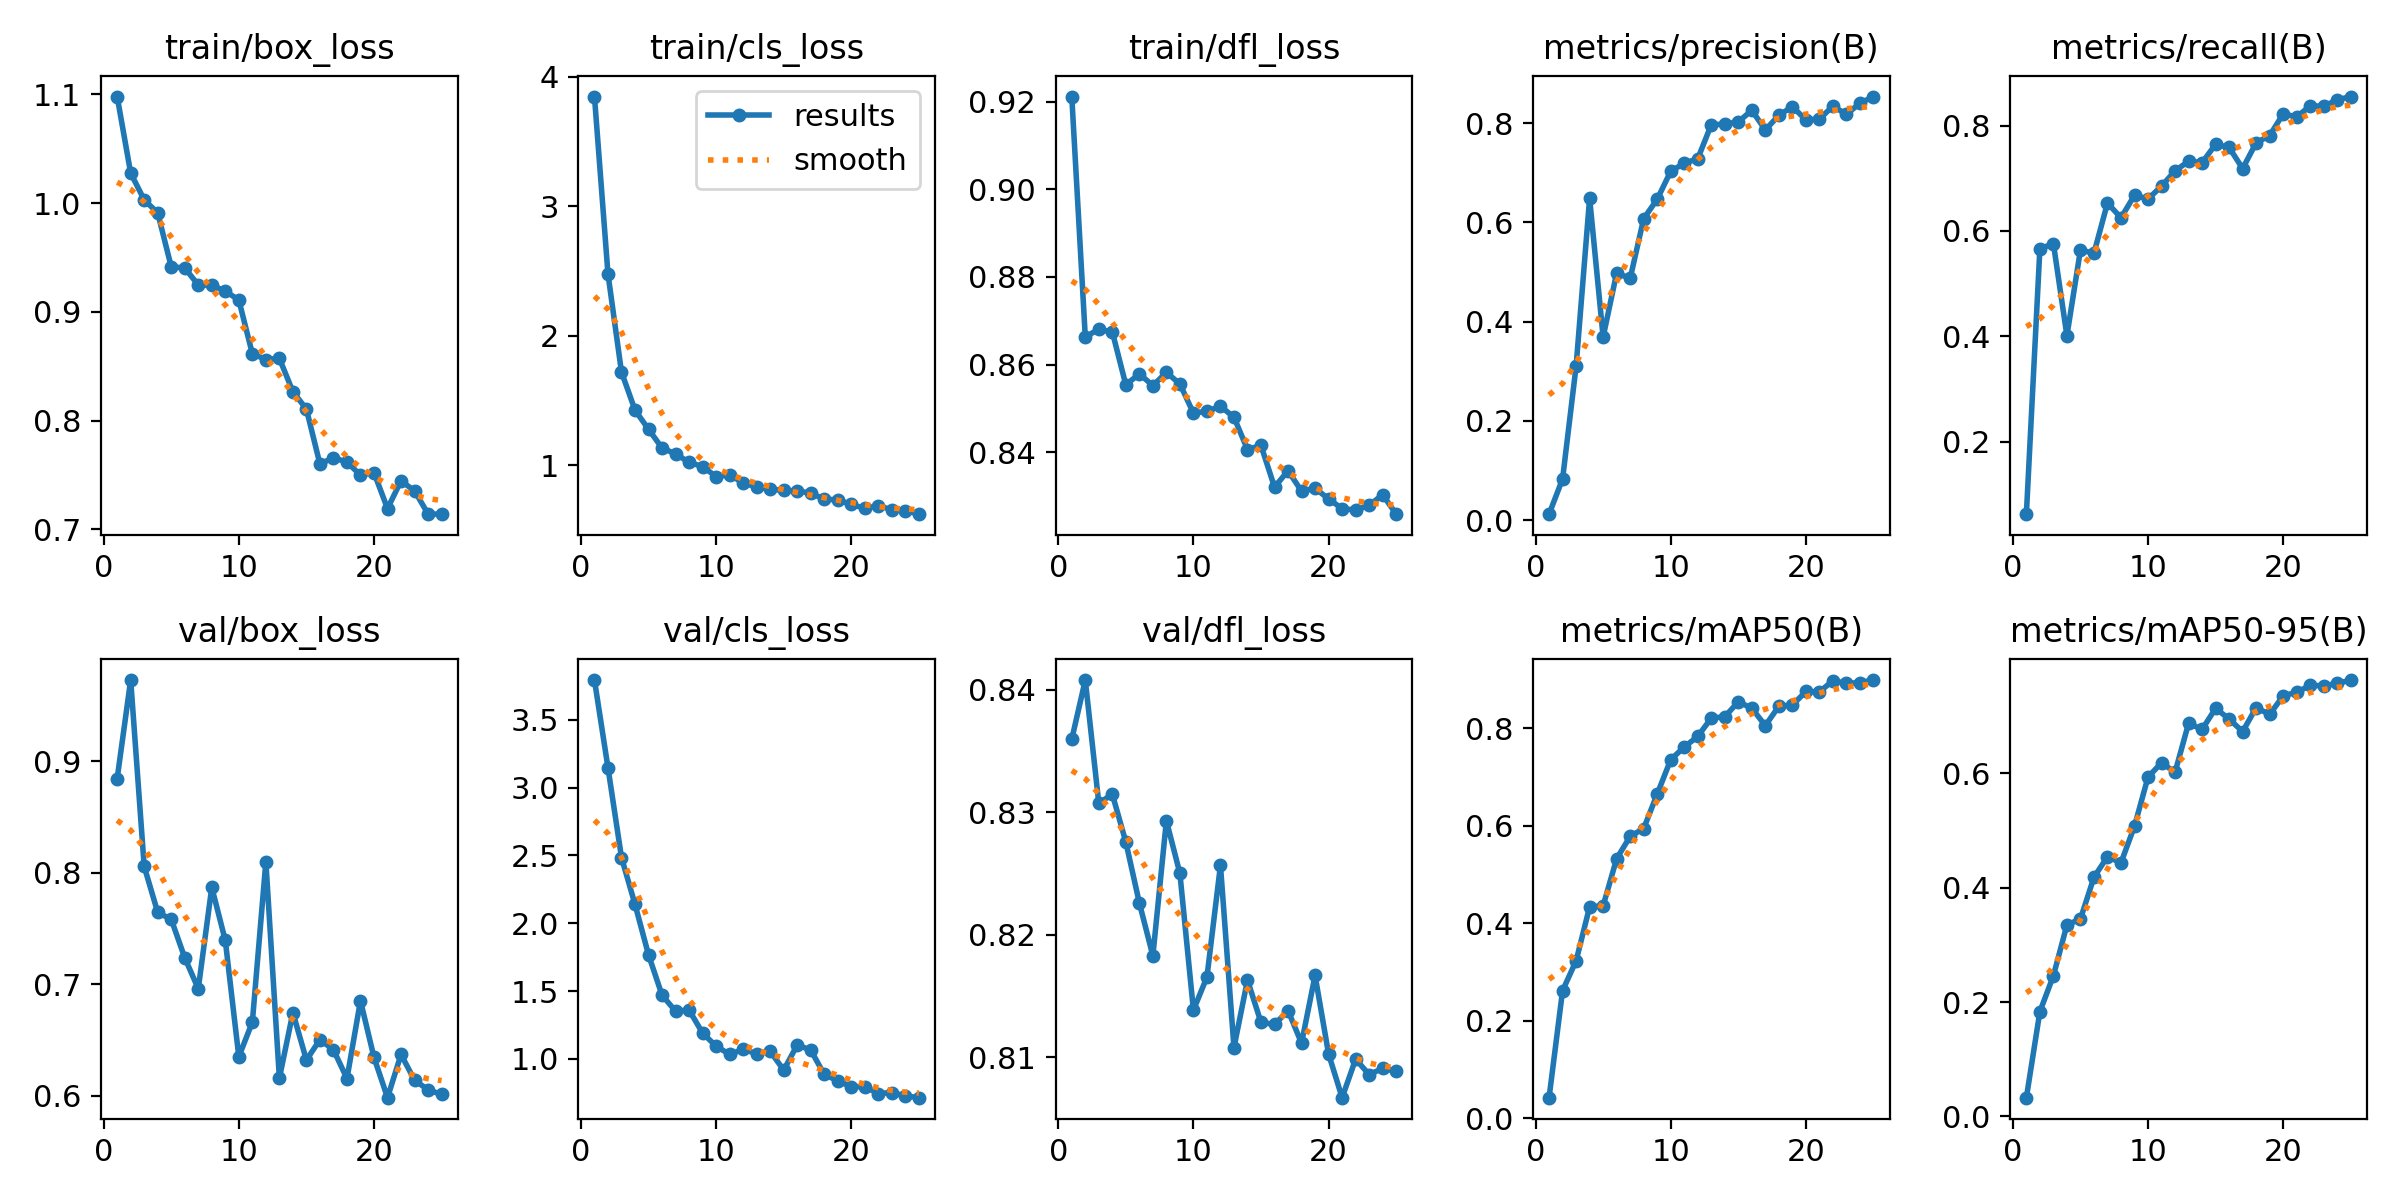


--- ACTUAL PREDICTIONS (What the AI sees) ---


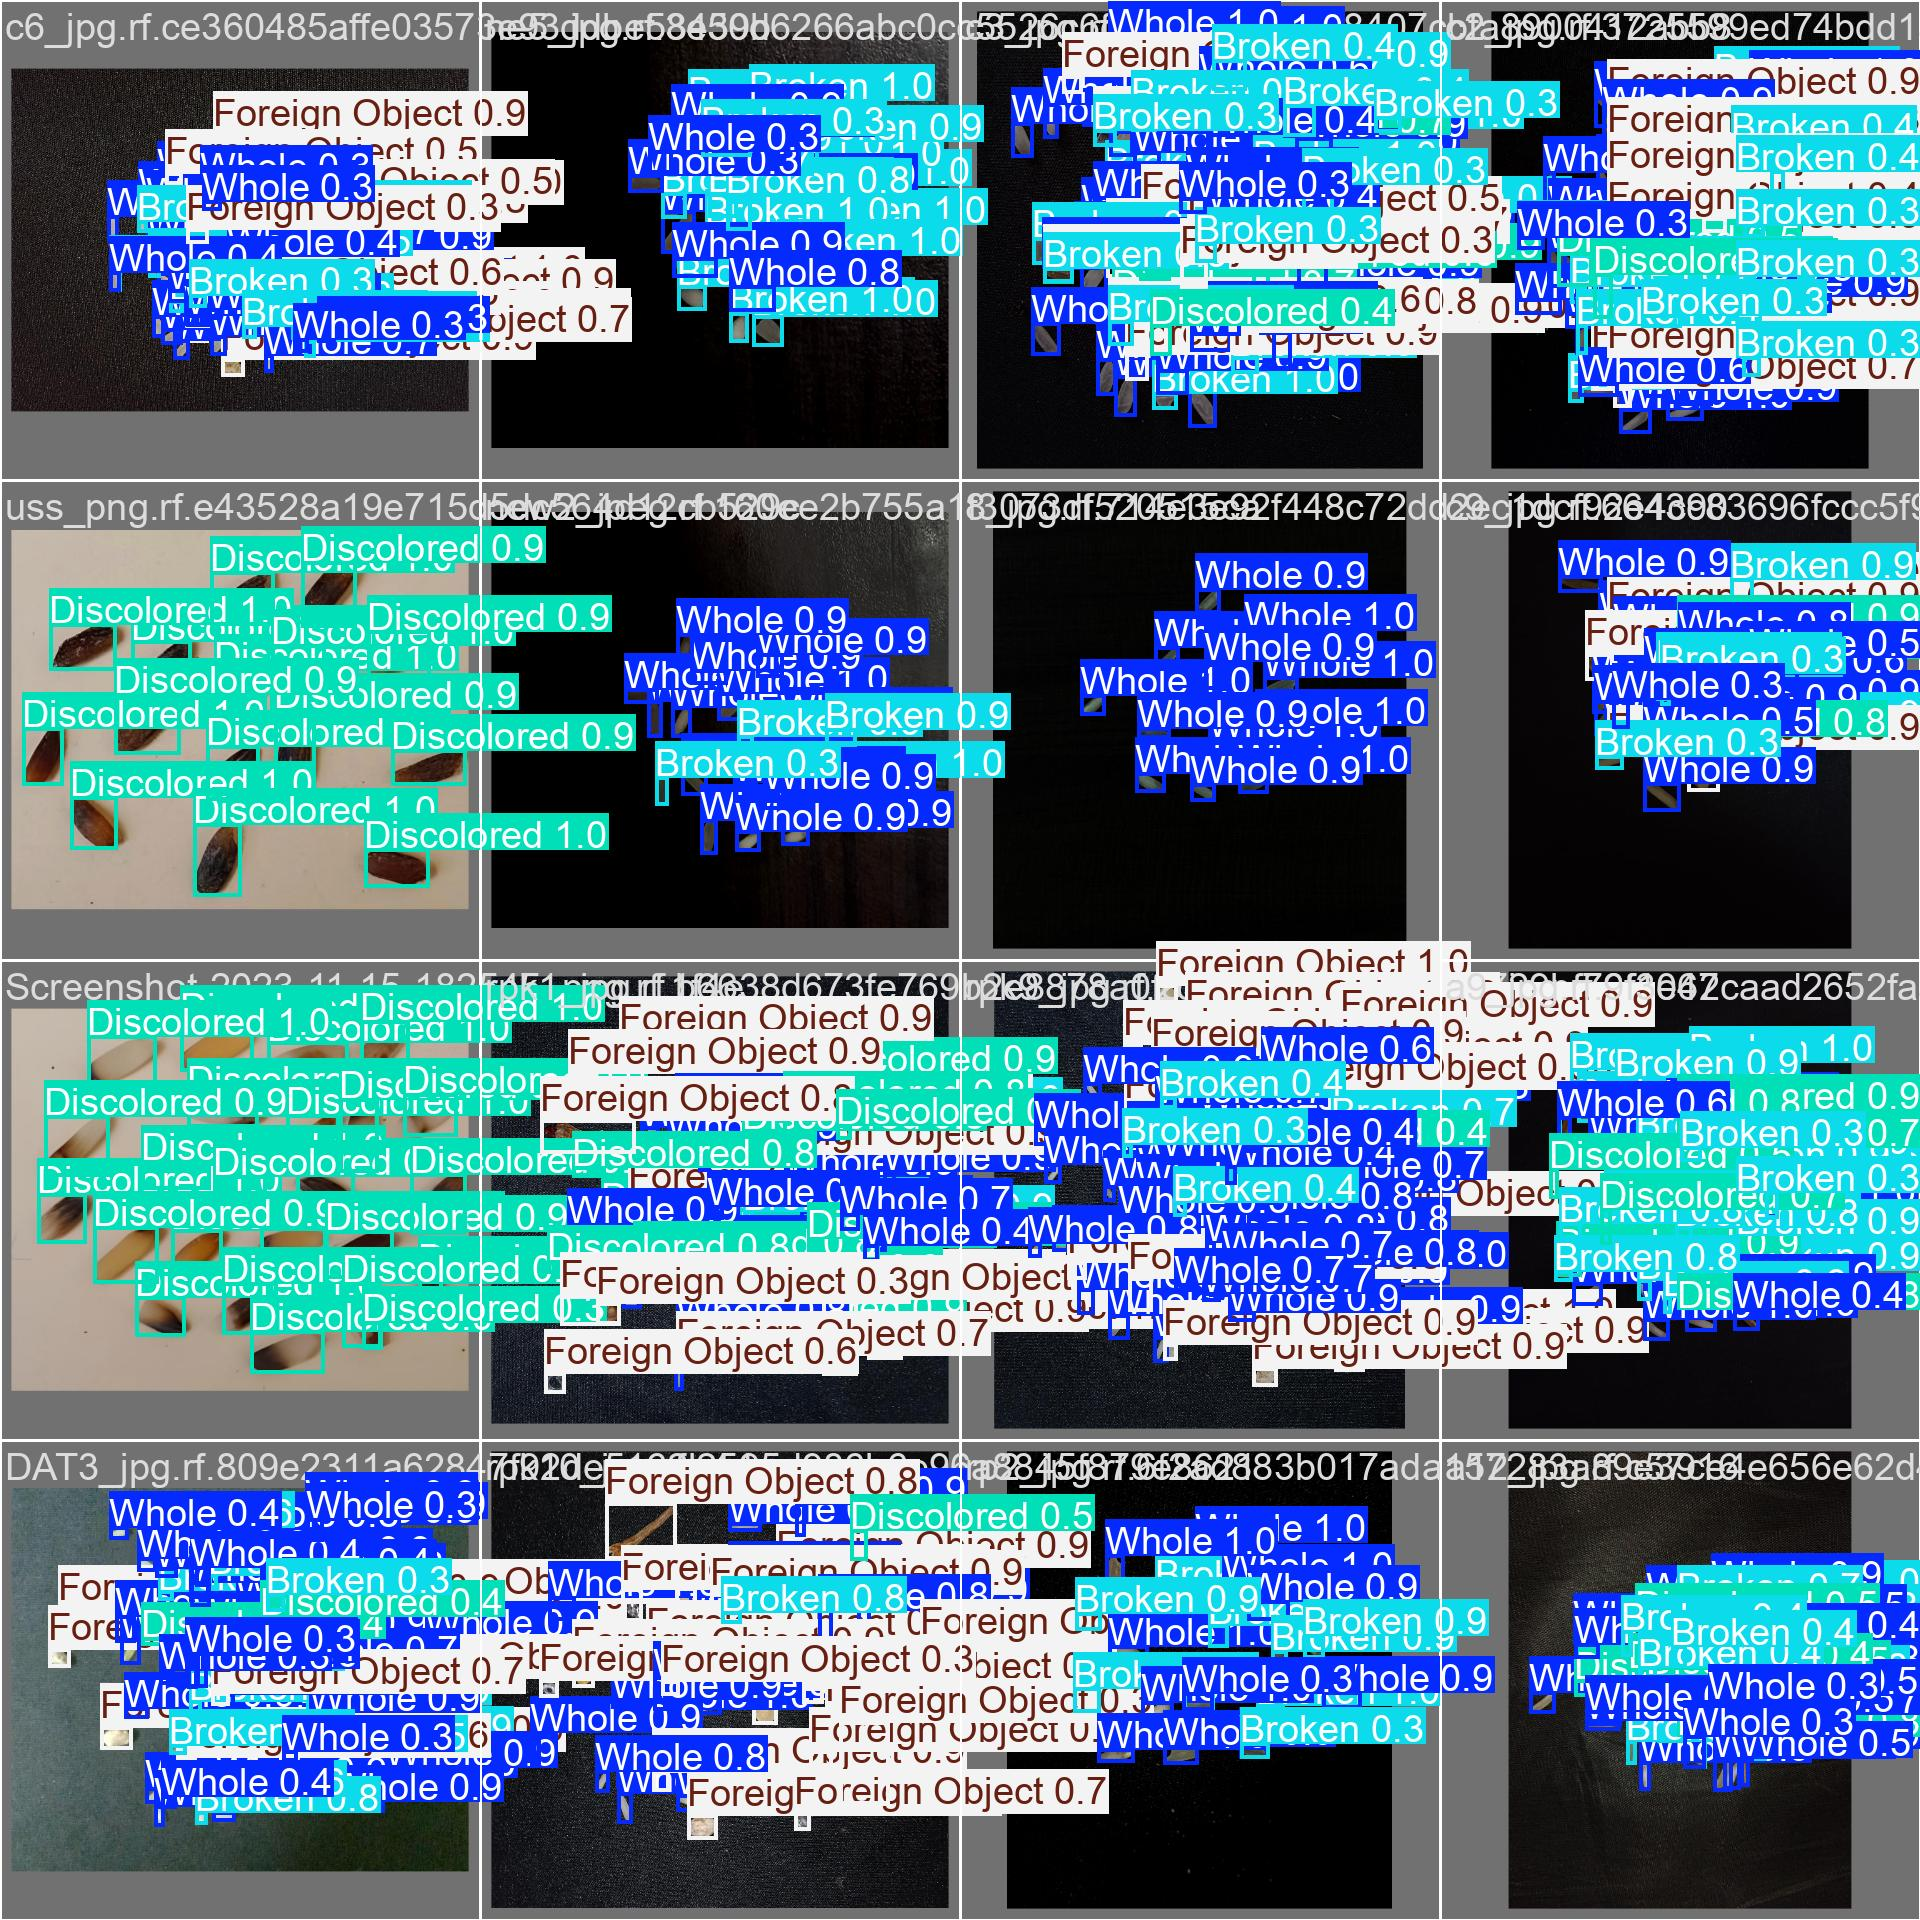

In [13]:
from IPython.display import Image, display

print("--Trainig Report Card (Graphs)--")
display(Image(filename='runs/detect/rice_physical_model_v1/results.png'))

print("\n--- ACTUAL PREDICTIONS (What the AI sees) ---")
display(Image(filename='runs/detect/rice_physical_model_v1/val_batch0_pred.jpg'))

Analyzing Image: /content/Rice-Quality-3-2/test/images/vidd_mp4-0000_jpg.rf.b011eb4beee4375946350f76d493ce41.jpg...

image 1/1 /content/Rice-Quality-3-2/test/images/vidd_mp4-0000_jpg.rf.b011eb4beee4375946350f76d493ce41.jpg: 640x384 12 Wholes, 3 Brokens, 7 Foreign Objects, 7 Discoloreds, 99.2ms
Speed: 4.3ms preprocess, 99.2ms inference, 8.5ms postprocess per image at shape (1, 3, 640, 384)

   RICE QUALITY ANALYSIS REPORT
Total Grains Scanned:   22
------------------------------
HEAD RICE (Whole):      12   (54.5%)
BROKEN RICE:            3    (13.6%)
DISCOLORED/DAMAGED:     7    (31.8%)
FOREIGN MATTER:         7    (Count)
------------------------------
PREDICTED GRADE:        GRADE 2


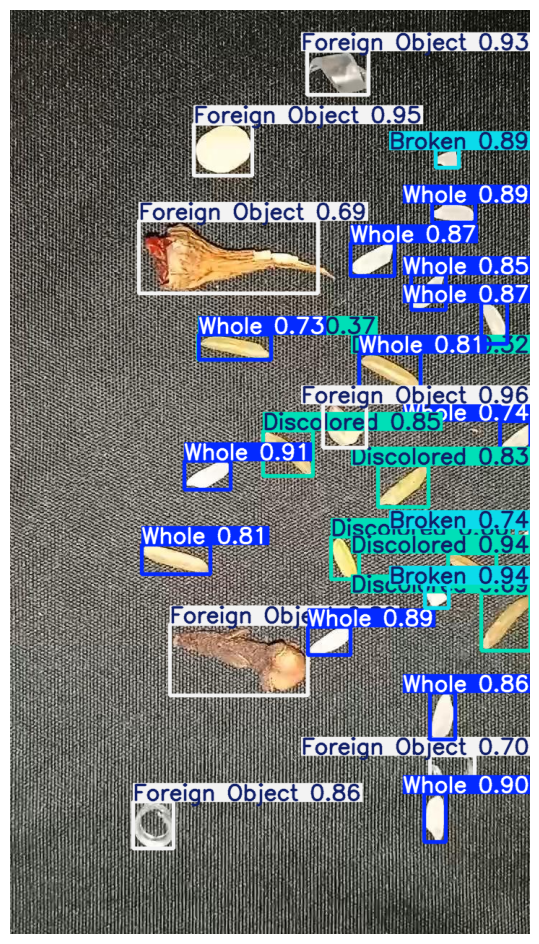

In [14]:
from ultralytics import YOLO
import glob
import cv2
import matplotlib.pyplot as plt

model = YOLO('runs/detect/rice_physical_model_v1/weights/best.pt')

test_images = glob.glob(f"{dataset.location}/test/images/*.jpg")
if len(test_images) == 0:
    test_images = glob.glob(f"{dataset.location}/valid/images/*.jpg")

target_image = test_images[0]

print(f"Analyzing Image: {target_image}...")

results = model.predict(target_image, conf=0.25)

whole_count = 0
broken_count = 0
foreign_count = 0
discolored_count = 0

for result in results:
    for box in result.boxes:
        class_id = int(box.cls[0])
        class_name = model.names[class_id]

        if class_name == 'Whole':
            whole_count += 1
        elif class_name == 'Broken':
            broken_count += 1
        elif class_name == 'Foreign Object':
            foreign_count += 1
        elif class_name == 'Discolored':
            discolored_count += 1

total_grains = whole_count + broken_count + discolored_count

if total_grains > 0:
    head_rice_pct = (whole_count / total_grains) * 100
    broken_pct = (broken_count / total_grains) * 100
    discolored_pct = (discolored_count / total_grains) * 100
else:
    head_rice_pct = 0
    broken_pct = 0
    discolored_pct = 0

grade = "GRADE 3"
if foreign_count == 0 and discolored_pct <= 0.5 and broken_pct < 5.0:
    grade = "PREMIUM"
elif foreign_count == 0 and discolored_pct <= 2.0 and broken_pct <= 10.0: # Approx Grade 1 limits
    grade = "GRADE 1"
elif broken_pct <= 25.0:
    grade = "GRADE 2"

print("\n" + "="*30)
print("   RICE QUALITY ANALYSIS REPORT")
print("="*30)
print(f"Total Grains Scanned:   {total_grains}")
print("-" * 30)
print(f"HEAD RICE (Whole):      {whole_count:<4} ({head_rice_pct:.1f}%)")
print(f"BROKEN RICE:            {broken_count:<4} ({broken_pct:.1f}%)")
print(f"DISCOLORED/DAMAGED:     {discolored_count:<4} ({discolored_pct:.1f}%)")
print(f"FOREIGN MATTER:         {foreign_count:<4} (Count)")
print("-" * 30)
print(f"PREDICTED GRADE:        {grade}")
print("="*30)

result_plot = results[0].plot()
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(result_plot, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [15]:
### TEST CODE ONLY FOR FINAL TESTING (DEMO)

# --- STEP 5: LIVE GRADING (PNS STANDARDS) ---
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# 1. Load your best trained model
model = YOLO('runs/detect/rice_physical_model_v1/weights/best.pt')

def grade_rice_sample(image_path):
    print(f"\nAnalyzing Sample: {image_path}...")

    # 2. Run Inference
    results = model.predict(image_path, conf=0.25)

    # 3. Count the Classes
    whole_count = 0
    broken_count = 0
    foreign_count = 0
    discolored_count = 0

    for result in results:
        for box in result.boxes:
            class_id = int(box.cls[0])
            # Map ID to Name using your specific training order
            # 0: Whole, 1: Broken, 2: Foreign Object, 3: Discolored
            if class_id == 0: whole_count += 1
            elif class_id == 1: broken_count += 1
            elif class_id == 2: foreign_count += 1
            elif class_id == 3: discolored_count += 1

    total_grains = whole_count + broken_count + discolored_count

    # 4. Calculate Percentages (PNS uses Weight, we use Count as Proxy)
    if total_grains == 0:
        print("No grains detected!")
        return

    head_rice_pct = (whole_count / total_grains) * 100
    broken_pct = (broken_count / total_grains) * 100
    discolored_pct = (discolored_count / total_grains) * 100

    # 5. DETERMINE GRADE (Official PNS Thresholds)
    # Default to "Substandard" (Below Grade 3)
    final_grade = "SUBSTANDARD (Fail)"

    # CHECK PREMIUM (Strictest)
    # Head Rice >= 95%, Broken < 5%, Discolored < 0.5%, Foreign = 0
    if (head_rice_pct >= 95.0 and
        discolored_pct <= 0.5 and
        foreign_count == 0):
        final_grade = "PREMIUM GRADE"

    # CHECK GRADE 1
    # Head Rice >= 80%, Broken < 20%, Discolored < 2.0%, Foreign <= 0.1%
    elif (head_rice_pct >= 80.0 and
          discolored_pct <= 2.0 and
          foreign_count <= 1): # Allow 1 foreign object tolerance
        final_grade = "GRADE 1"

    # CHECK GRADE 2
    # Head Rice >= 65%, Broken < 35%, Discolored < 4.0%
    elif (head_rice_pct >= 65.0 and
          discolored_pct <= 4.0):
        final_grade = "GRADE 2"

    # CHECK GRADE 3
    # Head Rice >= 50%, Broken < 50%, Discolored < 8.0%
    elif (head_rice_pct >= 50.0 and
          discolored_pct <= 8.0):
        final_grade = "GRADE 3"

    # 6. GENERATE REPORT
    print("="*40)
    print("      OFFICIAL QUALITY REPORT")
    print("="*40)
    print(f"Total Object Count:   {total_grains + foreign_count}")
    print("-" * 40)
    print(f"HEAD RICE (Whole):    {whole_count:<5} ({head_rice_pct:.1f}%)")
    print(f"BROKEN RICE:          {broken_count:<5} ({broken_pct:.1f}%)")
    print(f"DISCOLORED:           {discolored_count:<5} ({discolored_pct:.1f}%)")
    print(f"FOREIGN MATTER:       {foreign_count:<5} (Count)")
    print("-" * 40)
    print(f"CALCULATED GRADE:     {final_grade}")
    print("="*40)

    # Show Image
    res_plotted = results[0].plot()
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# --- RUN IT ON A TEST IMAGE ---
# Upload a photo of your own rice bag to Colab and change filename below!
# grade_rice_sample("my_jasmine_rice.jpg")

In [16]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
import os

source_path = 'runs/detect/rice_physical_model_v1/weights/best.pt'
destination_folder = '/content/drive/MyDrive/Thesis_Rice_Project/02_Saved_Models'
os.makedirs(destination_folder, exist_ok=True)

destination_path = f'{destination_folder}/rice_physical_v1.pt'

if os.path.exists(source_path):
    shutil.copy(source_path, destination_path)
    print(f"[SUCCESS] Model saved securely to: {destination_path}")
else:
    print("[ERROR] Could not find the model! Did you finish training?")

Mounted at /content/drive
[SUCCESS] Model saved securely to: /content/drive/MyDrive/Thesis_Rice_Project/02_Saved_Models/rice_physical_v1.pt


In [18]:
# load model (soon)

from ultralytics import YOLO
from google.colab import drive
drive.mount('/content/drive')

# Load the saved brain directly from Drive
model = YOLO('/content/drive/MyDrive/Thesis_Rice_Project/02_Saved_Models/rice_physical_v1.pt')

print("Model loaded successfully! Ready to grade rice.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded successfully! Ready to grade rice.
